## Home work 2

### Question 1

##### Part 1-2

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow import keras
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from keras.utils import to_categorical

In [2]:
def Read_Images(folder_paths):
    images = []
    labels = []
    for i,folder_path in enumerate(folder_paths):
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img = np.array(Image.open(os.path.join(folder_path, filename)))
                images.append(img)
                labels.append(i)
    return [np.array(images), np.array(labels)]

In [3]:
folder_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

train_path = 'Dataset_Part1/Train/'
tune_path = 'Dataset_Part1/Tune/'

train_folder_paths = []
tune_folder_paths = []

for folder_name in folder_names:
    train_folder_paths.append(os.path.join(train_path, folder_name))

for folder_name in folder_names:
    tune_folder_paths.append(os.path.join(tune_path, folder_name))

x, y = Read_Images(train_folder_paths)
x_tune, y_tune = Read_Images(tune_folder_paths)

num_classes = 8

x = x/255
x_tune = x_tune/255

print(x.shape)
print(y.shape)
print(x_tune.shape)
print(y_tune.shape)


(8000, 128, 128, 3)
(8000,)
(1600, 128, 128, 3)
(1600,)


In [4]:
T = x.shape[0]
batch_size = 40

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

augmented_data = data_generator.flow(x, y, batch_size=batch_size)

num_batches = int(0.2*T/batch_size)
x_mixed = [x]
y_mixed = [y]

for _ in range(num_batches):
    x_batch_augmented, y_batch_augmented = augmented_data.next()
    x_mixed.append(x_batch_augmented)
    y_mixed.append(y_batch_augmented)

x_mixed = np.concatenate(x_mixed, axis=0)
y_mixed = np.concatenate(y_mixed, axis=0)

x_train, x_test, y_train, y_test = train_test_split(x_mixed, y_mixed, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)

(7680, 128, 128, 3)
(7680,)


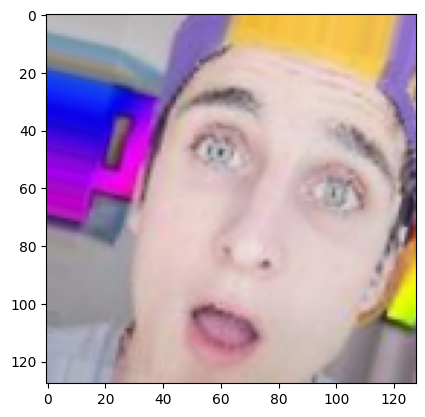

In [5]:
plt.imshow(x_batch_augmented[5,:,:,:])
plt.show()

##### Part 1-3

In [6]:
AlexNet = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=9, strides=1, padding="same", input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=10),

    keras.layers.Conv2D(filters=32, kernel_size=7, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=20),

    keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=30),

    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=40),

    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.GaussianDropout(0.2, seed=50),

    keras.layers.Flatten(),
    
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5, seed=10),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5, seed=20),

    keras.layers.Dense(8,activation='linear')
])

In [7]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

AlexNet.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
)

AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      3904      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 gaussian_dropout (GaussianD  (None, 64, 64, 16)       0         
 ropout)                                                         
                                                        

 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 gaussian_dropout_2 (Gaussia  (None, 16, 16, 64)       0         
 nDropout)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 re_lu_3 (

In [8]:
AlexNet.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    batch_size=80,
    epochs=32,
    shuffle=True
)

Epoch 1/32
96/96 [==============================] - 14s 74ms/step - loss: 2.3046 - accuracy: 0.1457 - val_loss: 2.0756 - val_accuracy: 0.1323
Epoch 2/32
96/96 [==============================] - 6s 65ms/step - loss: 2.0403 - accuracy: 0.1717 - val_loss: 2.0292 - val_accuracy: 0.1693
Epoch 3/32
96/96 [==============================] - 6s 66ms/step - loss: 1.8639 - accuracy: 0.2245 - val_loss: 1.8930 - val_accuracy: 0.2240
Epoch 4/32
96/96 [==============================] - 6s 66ms/step - loss: 1.8007 - accuracy: 0.2488 - val_loss: 1.7986 - val_accuracy: 0.2682
Epoch 5/32
96/96 [==============================] - 7s 68ms/step - loss: 1.7590 - accuracy: 0.2639 - val_loss: 1.7244 - val_accuracy: 0.3083
Epoch 6/32
96/96 [==============================] - 7s 69ms/step - loss: 1.7183 - accuracy: 0.2812 - val_loss: 1.6729 - val_accuracy: 0.3047
Epoch 7/32
96/96 [==============================] - 7s 68ms/step - loss: 1.6844 - accuracy: 0.3007 - val_loss: 1.6342 - val_accuracy: 0.3385
Epoch 8/32
9

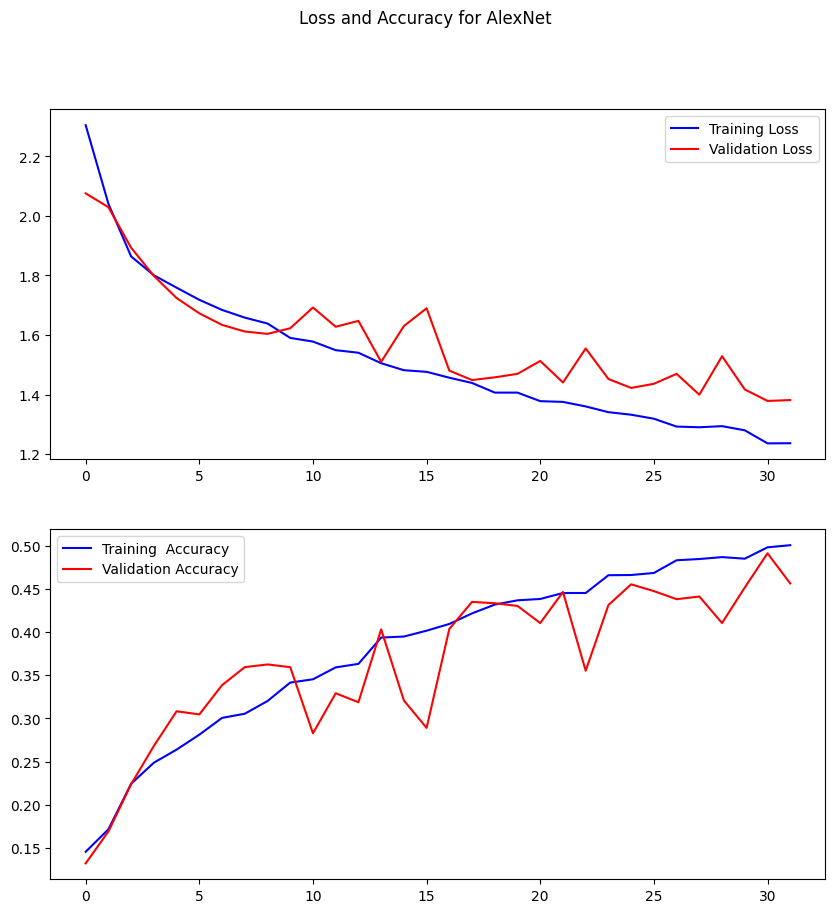

In [9]:
AlexNet.history.history.keys()
fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.suptitle('Loss and Accuracy for AlexNet')

ax[0].plot(AlexNet.history.history['loss'], color='b', label='Training Loss')
ax[0].plot(AlexNet.history.history['val_loss'], color='r', label='Validation Loss')
ax[0].legend()

ax[1].plot(AlexNet.history.history['accuracy'], color='b', label='Training  Accuracy')
ax[1].plot(AlexNet.history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax[1].legend()

plt.show()

In [10]:
y_pred_prob = tf.nn.softmax(AlexNet.predict(x_test))
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print("Total AlexNet accuracy:", accuracy)

60/60 [==============================] - 1s 20ms/step
Total AlexNet accuracy: 0.4557291666666667


---

In [11]:
AlexNetTuned = keras.models.clone_model(AlexNet)
AlexNetTuned.set_weights(AlexNet.get_weights())

for i in range(len(AlexNetTuned.layers)-5):
    AlexNetTuned.layers[i].trainable = False
for i in range(len(AlexNetTuned.layers)-5, len(AlexNetTuned.layers)):
    AlexNetTuned.layers[i].trainable = True

In [12]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

AlexNetTuned.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
)

AlexNetTuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      3904      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 gaussian_dropout (GaussianD  (None, 64, 64, 16)       0         
 ropout)                                                         
                                                        

In [13]:
AlexNetTuned.fit(
    x=x_tune,
    y=y_tune,
    validation_data=(x_test, y_test),
    batch_size=16,
    epochs=24,
    shuffle=True
)

Epoch 1/24
100/100 [==============================] - 2s 16ms/step - loss: 1.8116 - accuracy: 0.3031 - val_loss: 1.4704 - val_accuracy: 0.4411
Epoch 2/24
100/100 [==============================] - 1s 12ms/step - loss: 1.7126 - accuracy: 0.3313 - val_loss: 1.5256 - val_accuracy: 0.4250
Epoch 3/24
100/100 [==============================] - 1s 12ms/step - loss: 1.7084 - accuracy: 0.3319 - val_loss: 1.5275 - val_accuracy: 0.4297
Epoch 4/24
100/100 [==============================] - 1s 12ms/step - loss: 1.6776 - accuracy: 0.3400 - val_loss: 1.5082 - val_accuracy: 0.4422
Epoch 5/24
100/100 [==============================] - 1s 12ms/step - loss: 1.6421 - accuracy: 0.3613 - val_loss: 1.5814 - val_accuracy: 0.4125
Epoch 6/24
100/100 [==============================] - 1s 12ms/step - loss: 1.6469 - accuracy: 0.3481 - val_loss: 1.5228 - val_accuracy: 0.4411
Epoch 7/24
100/100 [==============================] - 1s 12ms/step - loss: 1.6239 - accuracy: 0.3575 - val_loss: 1.5358 - val_accuracy: 0.4484

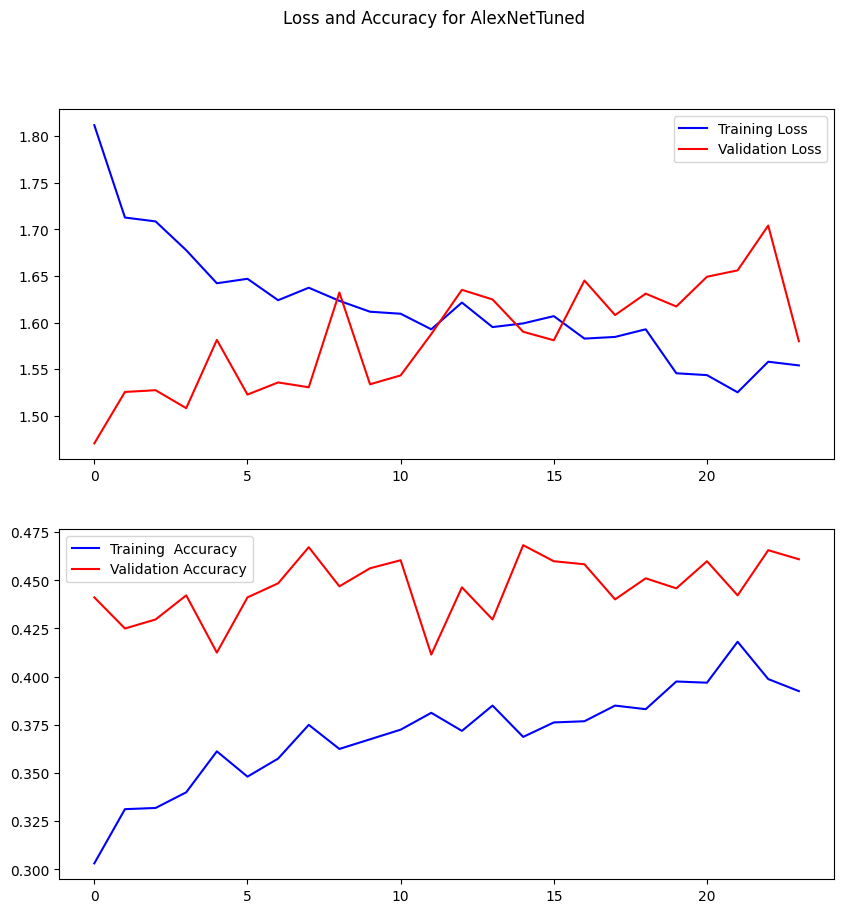

In [14]:
AlexNetTuned.history.history.keys()
fig, ax = plt.subplots(2,1,figsize=(10,10))
fig.suptitle('Loss and Accuracy for AlexNetTuned')

ax[0].plot(AlexNetTuned.history.history['loss'], color='b', label='Training Loss')
ax[0].plot(AlexNetTuned.history.history['val_loss'], color='r', label='Validation Loss')
ax[0].legend()

ax[1].plot(AlexNetTuned.history.history['accuracy'], color='b', label='Training  Accuracy')
ax[1].plot(AlexNetTuned.history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax[1].legend()

plt.show()

In [15]:
y_tune_pred_prob = tf.nn.softmax(AlexNetTuned.predict(x_test))
y_tune_pred = np.argmax(y_tune_pred_prob, axis=1)

accuracy_tune = accuracy_score(y_test, y_tune_pred)
print("Total AlexNetTuned accuracy:", accuracy_tune)

60/60 [==============================] - 1s 9ms/step
Total AlexNetTuned accuracy: 0.4609375


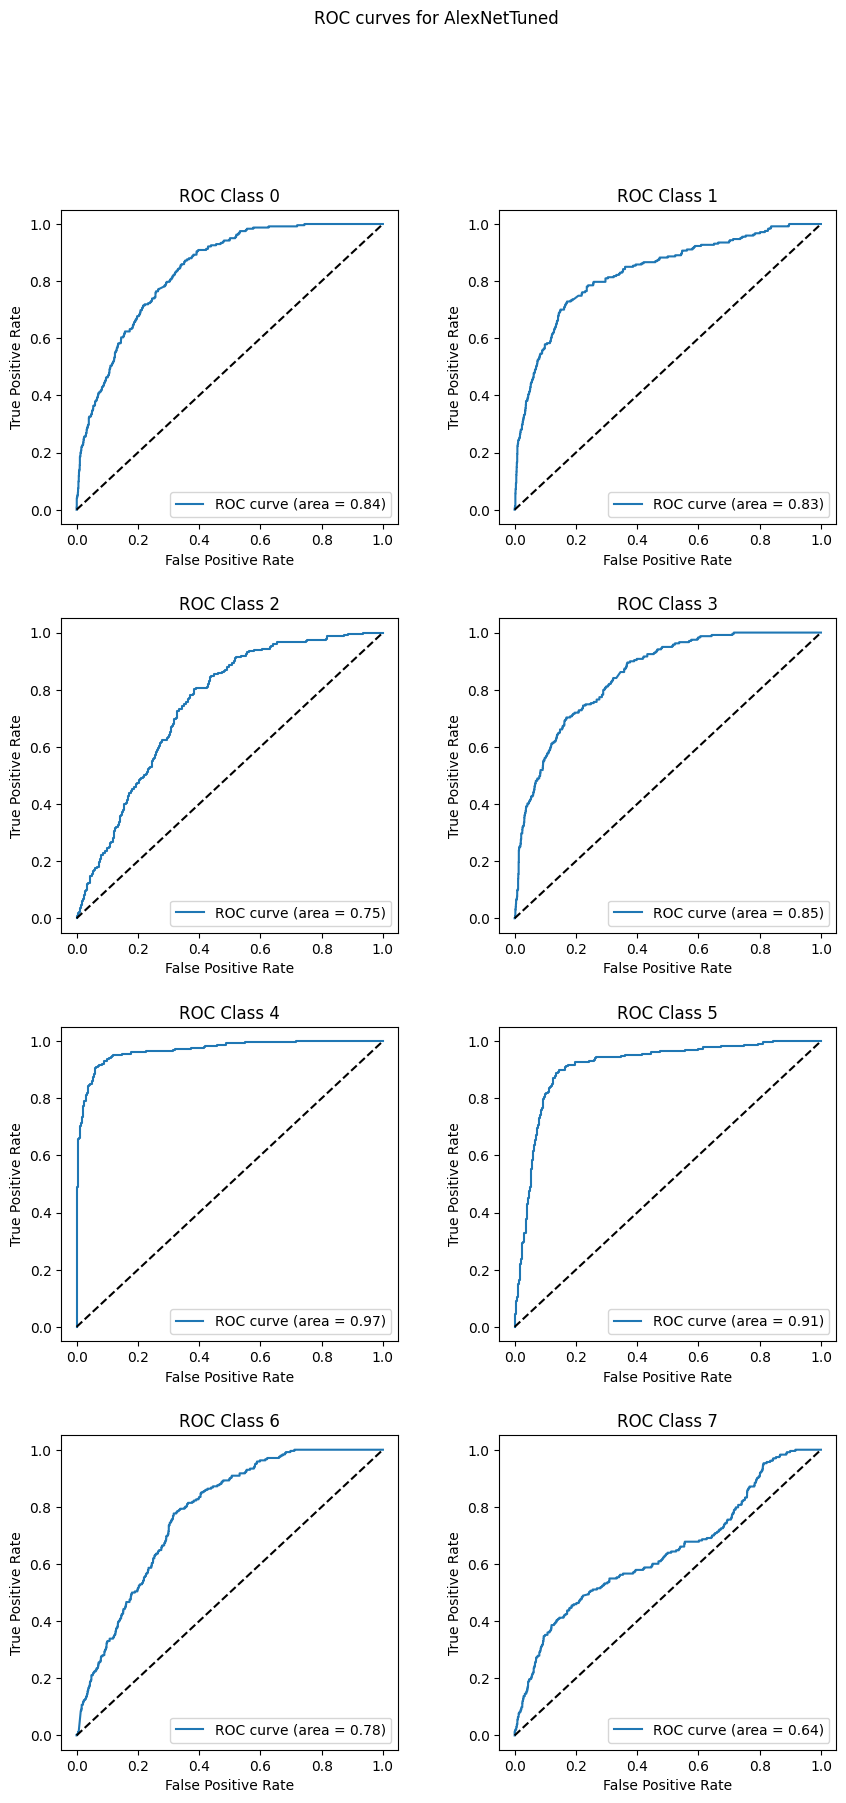

In [16]:
fig, axs = plt.subplots(4,2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.set_size_inches(10, 20)
fig.suptitle('ROC curves for AlexNetTuned')

for i in range(8):

    y_test_class = np.zeros(y_test.shape)
    y_test_class[y_test==i] = 1
    
    y_tune_pred_prob_class = y_tune_pred_prob[:, i]

    fpr, tpr, thresholds = roc_curve(y_test_class, y_tune_pred_prob_class, pos_label=1)
    roc_auc = auc(fpr, tpr)

    j = i%2
    axs[i//2][j].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[i//2][j].plot([0, 1], [0, 1], 'k--')

    axs[i//2][j].set_xlabel('False Positive Rate')
    axs[i//2][j].set_ylabel('True Positive Rate')
    axs[i//2][j].set_title(f'ROC Class {i}')
    axs[i//2][j].legend(loc="lower right")


In [17]:
for i in range(8):
    y_test_class = np.zeros(y_test.shape)
    y_test_class[y_test==i] = 1

    y_tune_pred_class = np.zeros(y_tune_pred.shape)
    y_tune_pred_class[y_tune_pred==i] = 1

    precision = precision_score(y_test_class, y_tune_pred_class)
    recall = recall_score(y_test_class, y_tune_pred_class)
    f1 = f1_score(y_test_class, y_tune_pred_class)

    print(f"Precision for class {i}: {round(precision, 3)}")
    print(f"Recall for class {i}: {round(recall, 3)}")
    print(f"F1-score for class {i}: {round(f1, 3)}\n")

Precision for class 0: 0.419
Recall for class 0: 0.256
F1-score for class 0: 0.318

Precision for class 1: 0.471
Recall for class 1: 0.559
F1-score for class 1: 0.511

Precision for class 2: 0.319
Recall for class 2: 0.185
F1-score for class 2: 0.234

Precision for class 3: 0.445
Recall for class 3: 0.54
F1-score for class 3: 0.488

Precision for class 4: 0.748
Recall for class 4: 0.866
F1-score for class 4: 0.803

Precision for class 5: 0.51
Recall for class 5: 0.745
F1-score for class 5: 0.606

Precision for class 6: 0.272
Recall for class 6: 0.405
F1-score for class 6: 0.326

Precision for class 7: 0.365
Recall for class 7: 0.099
F1-score for class 7: 0.155



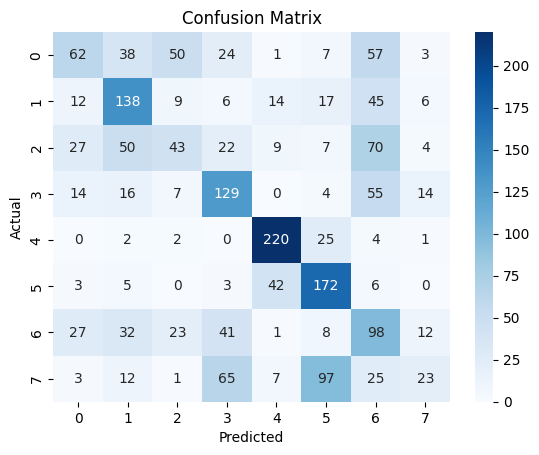

In [18]:
cm = confusion_matrix(y_test, y_tune_pred)

labels = np.unique(y_test)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

plt.title('Confusion matrix for AlexNetTuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)

plt.show()